#### Confirm data is well formed and other assumptions:
- On average, each scene comes with 19 different low resolution images and always with at least 9
- Same number of LR and QM
- Test our dataset class
- Visualize what we inputs/ouputs to the models

In [ ]:
import os
import glob

import skimage
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data_path = "Data/"

train = glob.glob(data_path +  "train/*/*") 
test = glob.glob(data_path + "test/*/*") 

In [ ]:
len(train + test)

### Check HR images 14 bit depth

In [437]:
max_ = 2**14
for i in range(0,  len(train)):
    image = tf.image.decode_png(tf.io.read_file(train[i]+"/HR.png"), dtype=tf.uint16)
    if max_ < image.numpy().max():
        print(train[i]+"/HR.png")
        max_ = image.numpy().max()
        
print(max_)
print(2**14)


Data/train/RED/imgset0268/HR.png
Data/train/RED/imgset0252/HR.png
Data/train/RED/imgset0468/HR.png
Data/train/NIR/imgset1025/HR.png
21520
16384


### 4 HR images have values encoded in more than 14 bits

Quick check to see HR reflectences distributions

In [ ]:
plt.figure(figsize=(12,12));
for i in range(0,  len(train)):
    if i%1 == 0:
        image = tf.image.decode_png(tf.io.read_file(train[i]+"/HR.png"), dtype=tf.uint16)
        plt.hist(image.numpy().flatten(), bins=50);

We assume these are outliers and we will only consider 14bits

In [37]:
tf.cast(image / 2**14, tf.float32)

<tf.Tensor: id=16, shape=(384, 384, 1), dtype=float32, numpy=
array([[[0.12936804],
        [0.12862453],
        [0.133829  ],
        ...,
        [0.11375464],
        [0.1070632 ],
        [0.10929368]],

       [[0.15241636],
        [0.1330855 ],
        [0.12267658],
        ...,
        [0.11375464],
        [0.11672863],
        [0.12044609]],

       [[0.14052045],
        [0.12713754],
        [0.11747212],
        ...,
        [0.1063197 ],
        [0.11301115],
        [0.11672863]],

       ...,

       [[0.11672863],
        [0.1330855 ],
        [0.13457249],
        ...,
        [0.14498141],
        [0.14498141],
        [0.13828996]],

       [[0.11524164],
        [0.13159852],
        [0.14498141],
        ...,
        [0.1472119 ],
        [0.13977695],
        [0.14052045]],

       [[0.12713754],
        [0.1197026 ],
        [0.133829  ],
        ...,
        [0.17620818],
        [0.15762082],
        [0.14944237]]], dtype=float32)>

In [ ]:
class SuperResolutionHelper:
    """Class with helper functions for typical super resolution operations:
        Baseline upscale 
        Bicubic upscale
        Central Tendency
    """
    
    

In [438]:
from typing import List
class Scene() :
    """Data holder for scene images paths containing list of paths and paths to all
    relevant images in the scene
    """
    
    def __init__(self, qms: List[str], lrs: List[str], sm: str, hr: str=None):
        self.qms = qms
        self.lrs = lrs
        self. sm = sm
        self.hr = hr

In [459]:
PATCH_SIZE = 32
LR_HR_RATIO = 3

class ProbaVDataset():
    """Management of the proba-v-super-resolution challenge's data.
    1) Check if the provided data matches the hypothesis
    2) Load images/patches
    3) ...
    
    Attributes:
        data_dir: string path to the Data folder (containing the train and test folders)
    """
    
    def __init__(self, data_dir: str):
        self.train_samples = glob.glob(data_path +  "train/*/*") 
        self.test_samples = glob.glob(data_path + "test/*/*")
        
        self._check_dataset()
        
        # We store current pivot to vizualize, a bit hacky for now
        self.pivot = None
    
    def _check_dataset(self):
        """Check that the downloaded data respects the following
            - always with at least 9 QM/LR
            - Same number of LR and QM
            - SM/HR exists
        """
        for scene_path in self.train_samples + self.test_samples:
            scene = self.get_scene_content(scene_path)
            assert (len(scene.qms) >= 9), "Less than 9 images at scene" + scene_path
            assert (len(scene.lrs) == len(scene.qms)), "Number of QMS and LRS images are not identical at scene " + scene_path
            assert (os.path.isfile(scene.sm)), "Missing SM image at scene " + scene_path
            if scene_path.split("/")[1] == "train":
                assert (os.path.isfile(scene.hr)), "Missing HR image at scene " + scene_path
        
    def get_scene_content(self, scene_path: str):
        """Finds the file for a given scene (folder) in the dataset

            Args:
                scene_path: The path to scene's folder

            Returns
                a Scene object (see Scene class)
        """
        qms = glob.glob(scene_path + "/QM*.png")
        lrs = glob.glob(scene_path + "/LR*.png")
        sm = scene_path + "/SM.png"
        hr = scene_path + "/HR.png"
        
        return Scene(qms, lrs, sm, hr)
    
    def load_image(self, img_path, is_quality_map=False):
        image = tf.image.decode_png(tf.io.read_file(img_path), dtype=tf.uint16)
        input_image = tf.cast(image, tf.float32)
        if not is_quality_map:
            return input_image / max_
        else:
            return input_image
        
    # Jitter is basically 40 - 32
    def load_qms_lrs_patches(self, scene: Scene, pivot: tf.Tensor, jitter: int=8):
        j_d = (int)((PATCH_SIZE + 8) / 2)
        h,w = pivot
        
        slices = [slice(h - j_d, h + j_d), slice(w - j_d, w + j_d), 0]
        qm_tensors = [self.load_image(path, True)[slices] for path in scene.qms]
        lr_tensors = [self.load_image(path)[slices] for path in scene.lrs]

        # Contains list of [qm, lr] tensors pairs 
        patches_stack = [tf.stack([qm, lr], axis=0) for qm, lr in zip(qm_tensors, lr_tensors)]
        return patches_stack
    
    def load_hr_sm(self, scene: Scene):
        hr = self.load_image(scene.hr)
        sm = self.load_image(scene.sm, True)
        return sm, hr
    
    def visuzalize(self, scene: Scene):
        """ Shows an example of input output 
        """
        # Get scene tensors
        stack_cropped, label = self.get_random_patch_stack_and_label(scene)
        
        fig = plt.figure(figsize=(25,25))
        i = 1
        for s_c in stack_cropped:
            ax = plt.subplot(15,4,i)
            ax.axis('off');
            plt.imshow(s_c[0], cmap="copper", vmin=0, vmax=255)
            ax = plt.subplot(15,4,i+1)
            ax.axis('off');
            plt.imshow(s_c[1], vmin=0, vmax=1)
            i += 2
            
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(1,2,1)
        ax.axis('off');
        plt.imshow(label[0], cmap="copper", vmin=0, vmax=255)
        ax = plt.subplot(1,2,2)
        ax.axis('off');
        plt.imshow(label[1], vmin=0, vmax=1)
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,2,1)
        ax.axis('off');
        ax.add_patch(matplotlib.patches.Rectangle((self.pivot[1]*3 - 48, self.pivot[0]*3 - 48), 96, 96, color="red", alpha=0.3))
        plt.imshow(self.load_image(scene.sm)[:,:,0], cmap="copper", vmin=0, vmax=255)
        
        ax = fig.add_subplot(1,2,2)
        ax.axis('off');
        plt.imshow(self.load_image(scene.hr)[:,:,0], vmin=0, vmax=1)
        ax.add_patch(matplotlib.patches.Rectangle((self.pivot[1]*3 - 48, self.pivot[0]*3 - 48), 96, 96, color="red", alpha=0.3))
        plt.show()
    
    # Todo func name and break
    # now we can see benefit of Scene class
    def get_random_patch_stack_and_label(self, scene: Scene):
        pivot = ds.get_pivot().numpy()
        self.pivot = pivot
        
        jitter = 8
        patches_stack = self.load_qms_lrs_patches(scene, pivot, jitter)
        # Get Random crop from 40 (depends on jitter) by 40 patch
        stack_cropped = [tf.image.random_crop(patch, size=[2, PATCH_SIZE, PATCH_SIZE]) for patch in patches_stack]
        
        # Get label at pivot point
        sm, hr = self.load_hr_sm(scene)
        j_d = (int)(PATCH_SIZE * LR_HR_RATIO / 2)
        h,w = pivot * 3
        
        slices = [slice(h - j_d, h + j_d), slice(w - j_d, w + j_d), 0]
        label = tf.stack([sm[slices], hr[slices]], axis=0)
        return stack_cropped, label
    
    def get_pivot(self, grid_size:int =128, border_size: int=40):
        return tf.random.uniform([2], border_size, grid_size-border_size, dtype=tf.dtypes.int32)
    
    # Patch random jitter strategy
    # Since images aren't perfectly alligned
    def random_jitter(patches):
        pass

In [460]:
ds = ProbaVDataset(data_path)

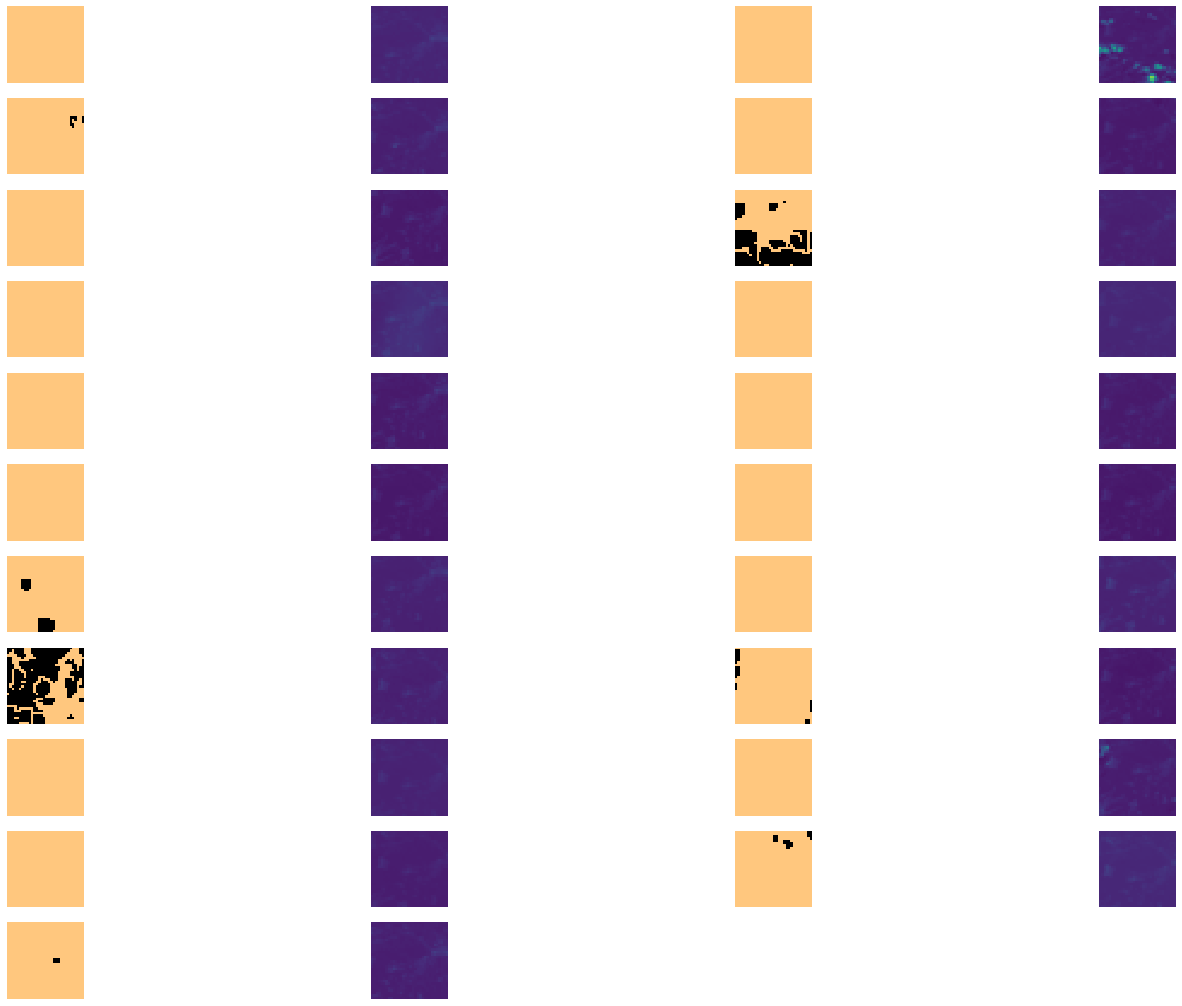

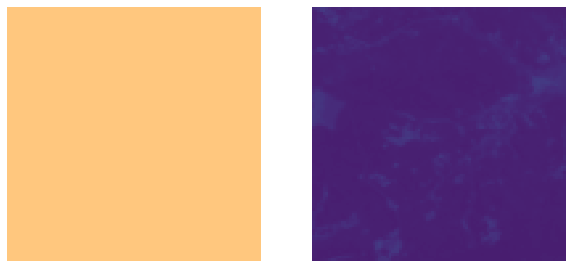

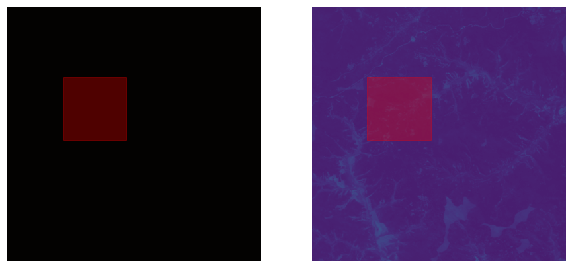

In [461]:
scene = ds.get_scene_content(ds.train_samples[45])
ds.visuzalize(scene)

In [409]:
patch, label = ds.get_random_patch_stack_and_label(scene)

In [319]:
label

<tf.Tensor: id=37156, shape=(2, 96, 96), dtype=uint8, numpy=
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[  7,   7,   8, ...,  13,  14,  14],
        [  8,   7,   7, ...,  13,  14,  14],
        [  9,   8,   8, ...,  13,  13,  14],
        ...,
        [ 11,  13,  15, ...,  14,  14,  14],
        [ 11,  14,  13, ...,  14,  14,  14],
        [ 11,  12,   9, ...,  14,  14,  14]]], dtype=uint8)>

In [402]:
print(max_)
print(2**14)

17984
16384


In [ ]:
2**15

# Eurosat BANDS: (Sentinel2), could use band 8
- Band 1 - Coastal aerosol	0.443	60
- Band 2 - Blue	0.490	10
- Band 3 - Green	0.560	10
- Band 4 - Red	0.665	10
- Band 5 - Vegetation Red Edge	0.705	20
- Band 6 - Vegetation Red Edge	0.740	20
- Band 7 - Vegetation Red Edge	0.783	20
- Band 8 - NIR	0.842	10
- Band 8A - Vegetation Red Edge	0.865	20
- Band 9 - Water vapour	0.945	60
- Band 10 - SWIR - Cirrus	1.375	60
- Band 11 - SWIR	1.610	20
- Band 12 - SWIR	2.190	20

##### Band 8 – NIR	10m Spatial resolution (m)

In [129]:
import rasterio

def load_raster_img(path):
    raster = rasterio.open(path)
    return raster.read(8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


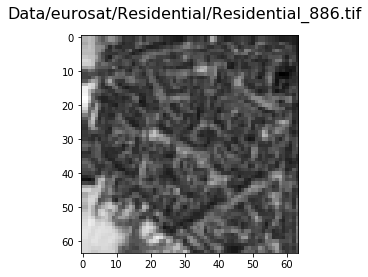

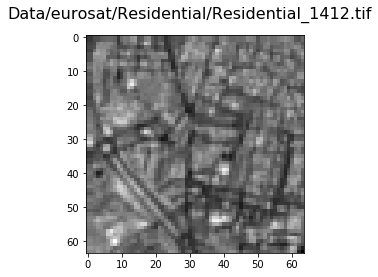

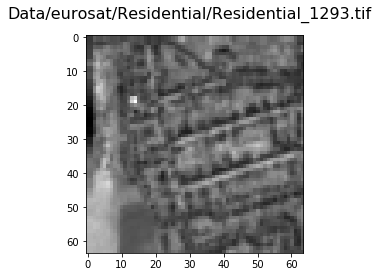

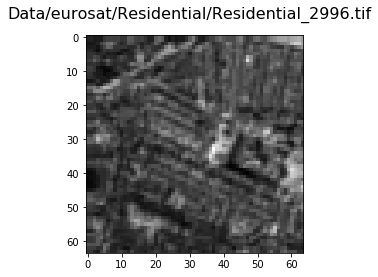

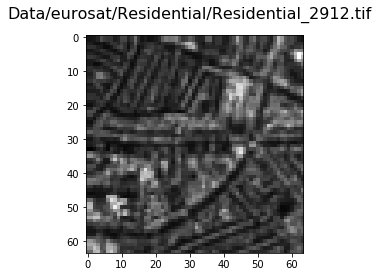

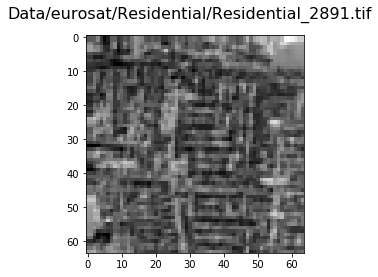

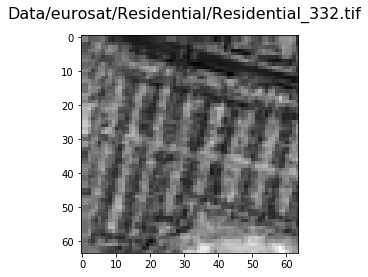

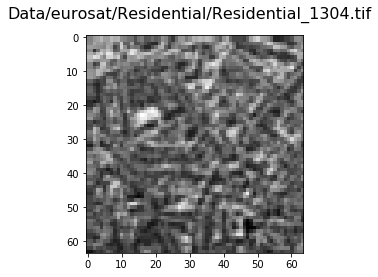

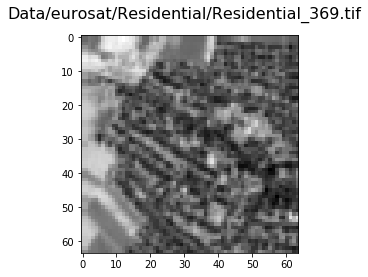

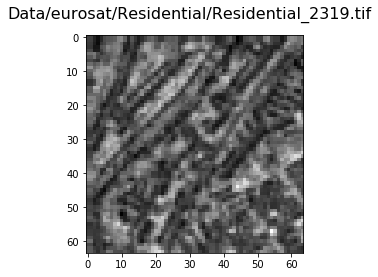

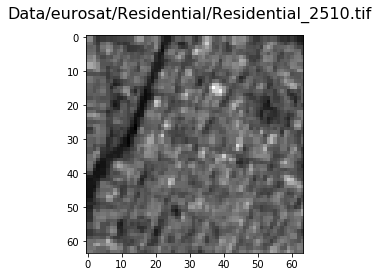

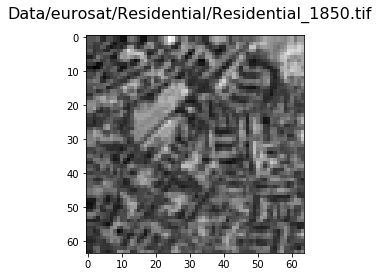

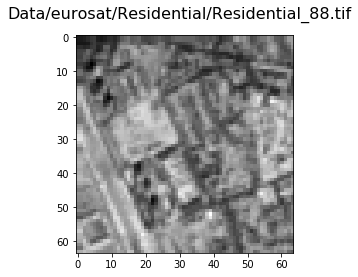

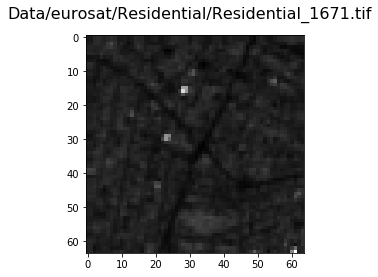

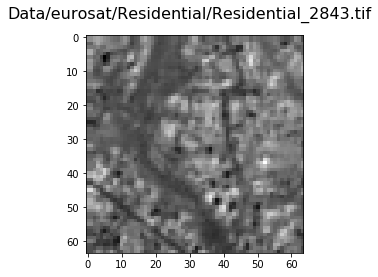

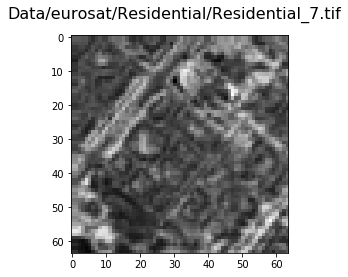

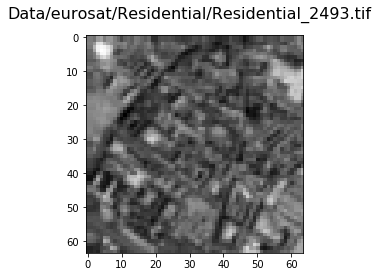

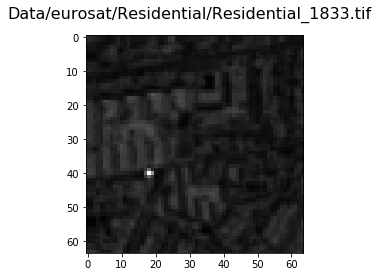

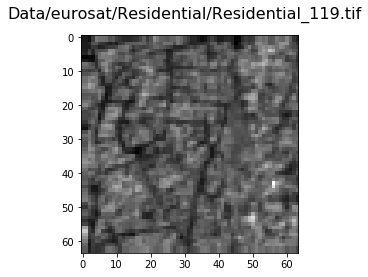

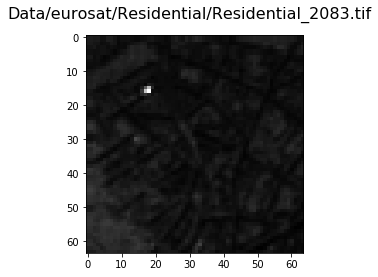

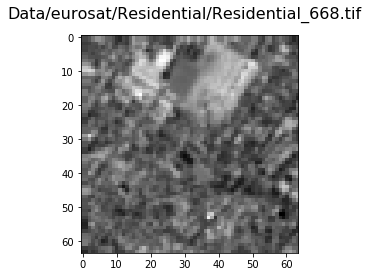

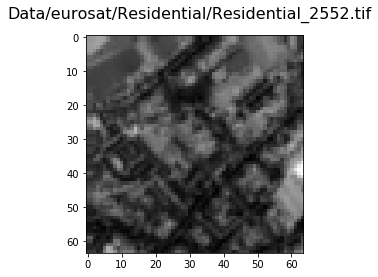

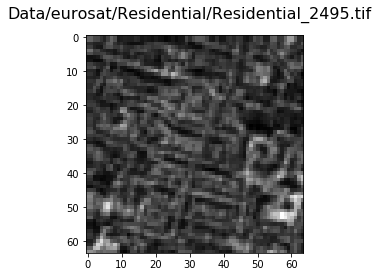

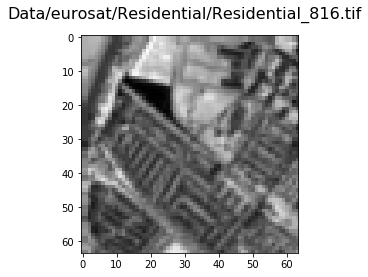

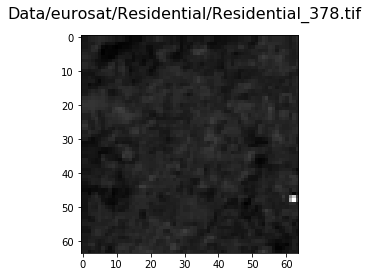

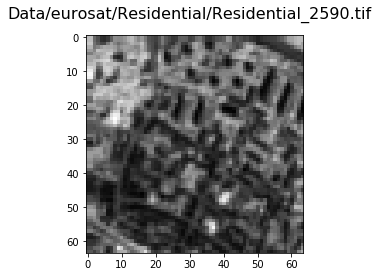

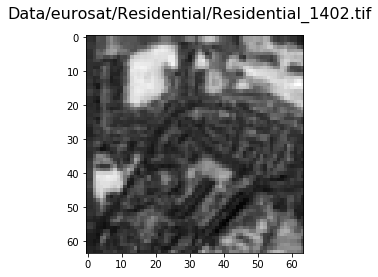

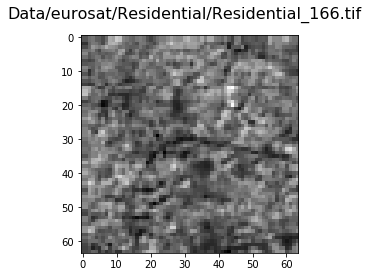

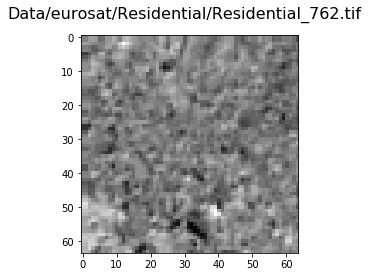

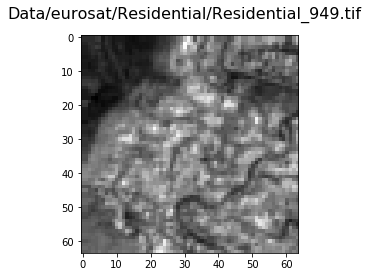

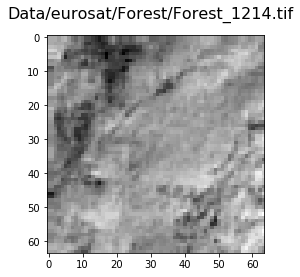

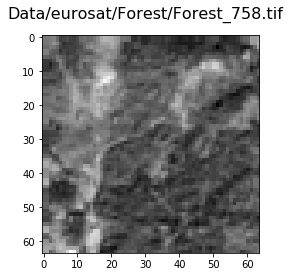

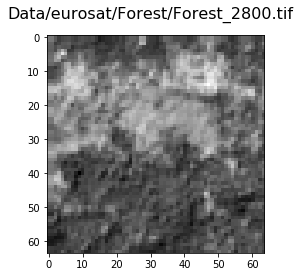

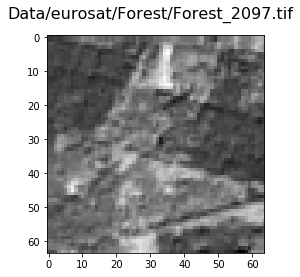

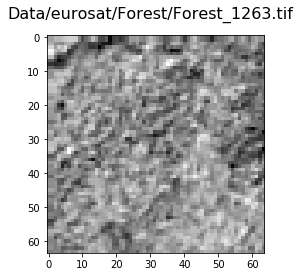

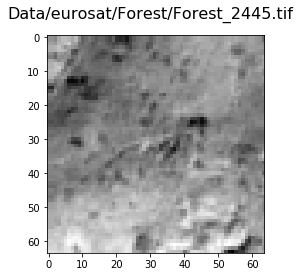

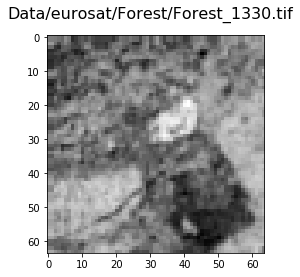

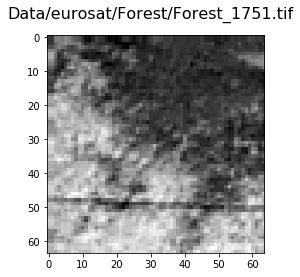

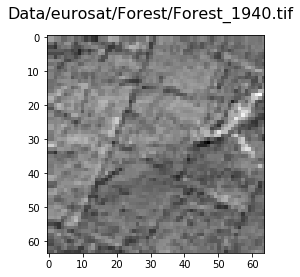

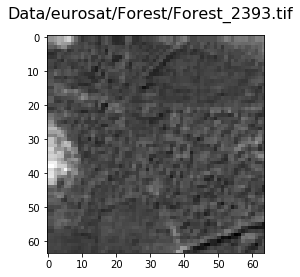

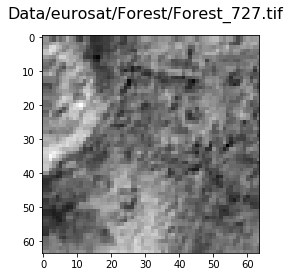

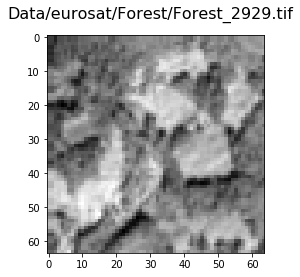

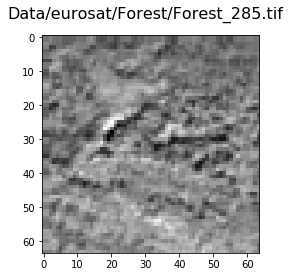

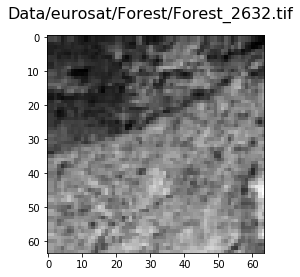

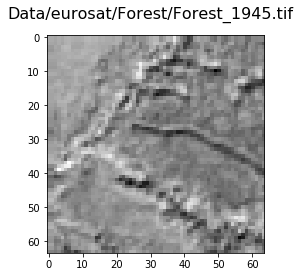

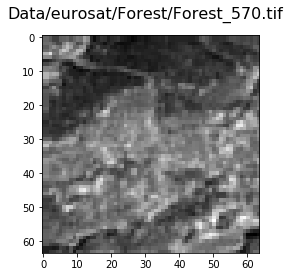

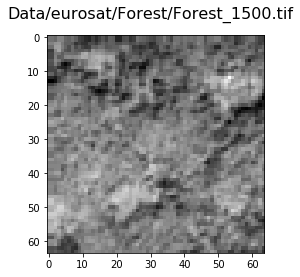

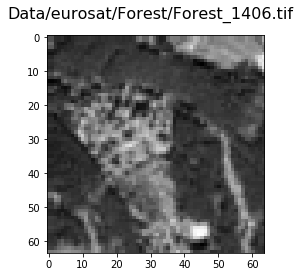

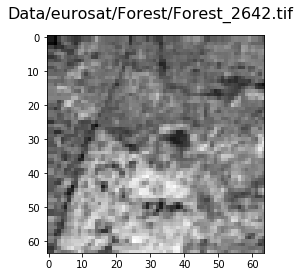

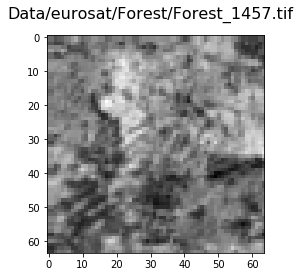

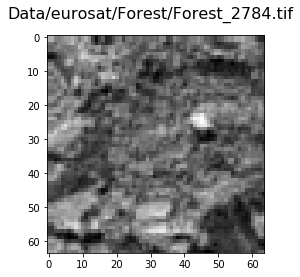

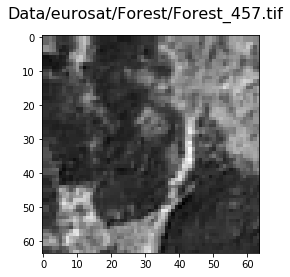

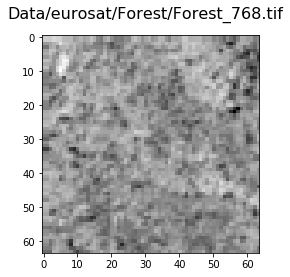

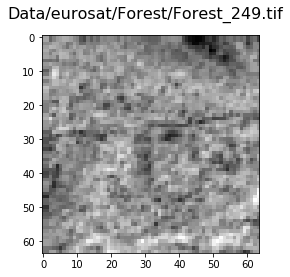

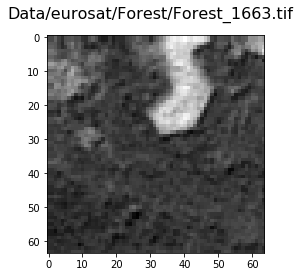

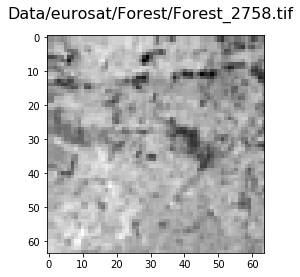

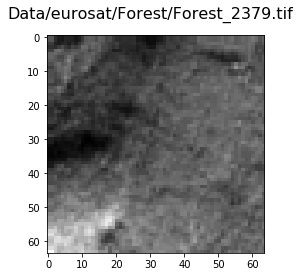

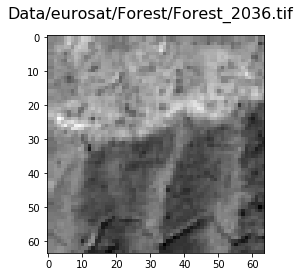

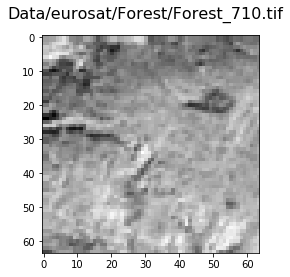

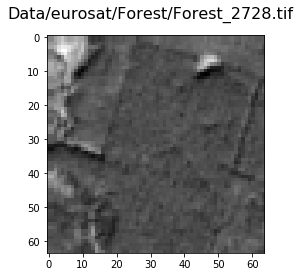

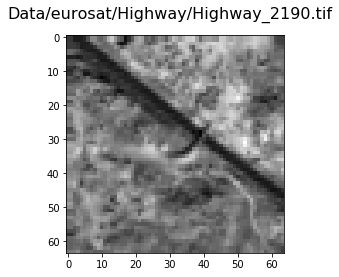

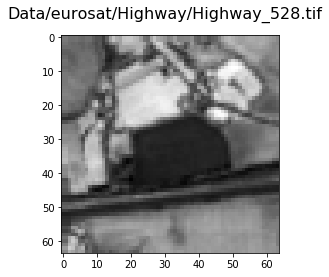

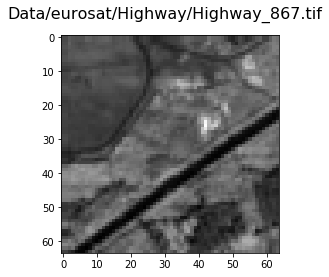

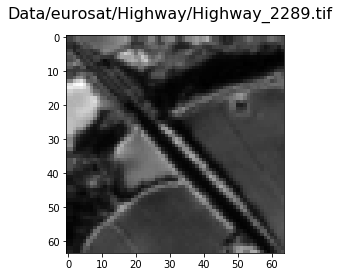

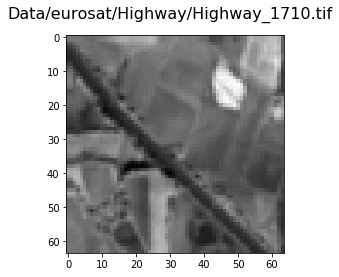

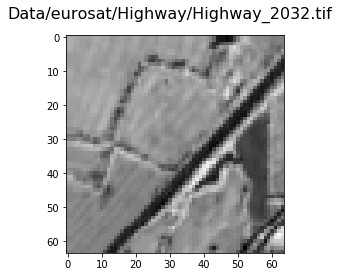

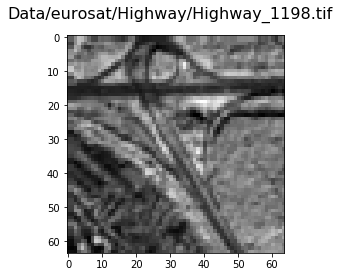

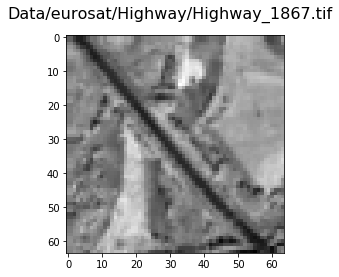

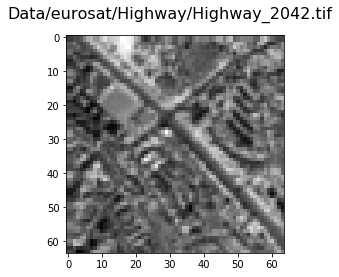

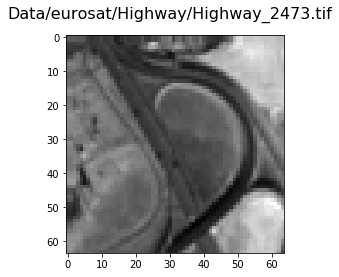

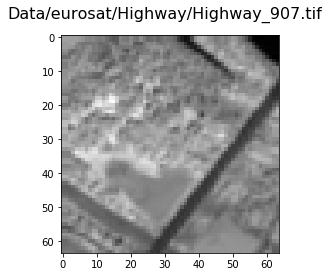

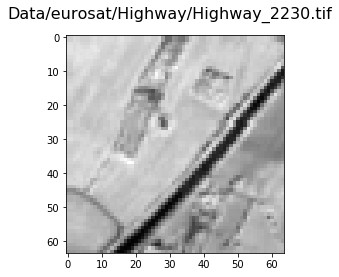

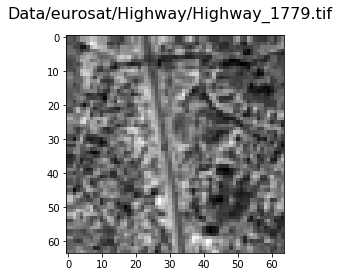

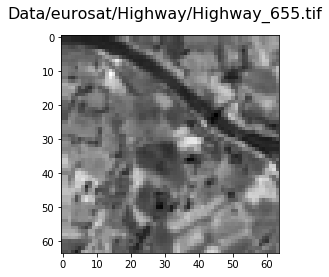

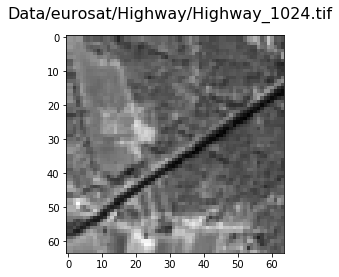

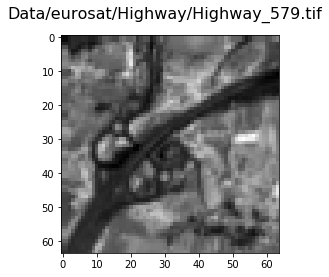

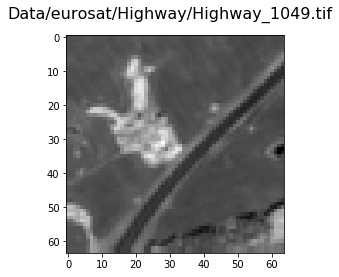

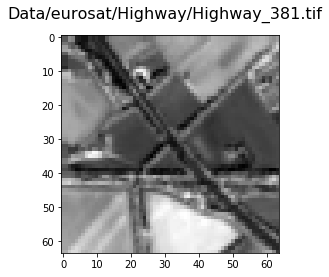

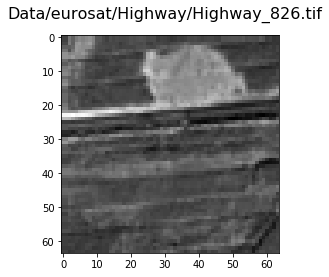

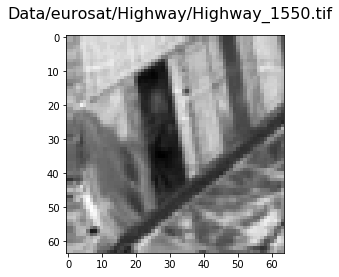

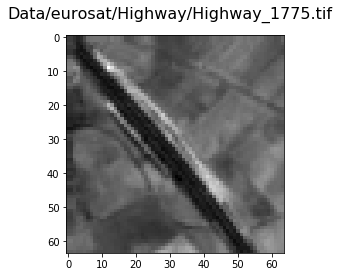

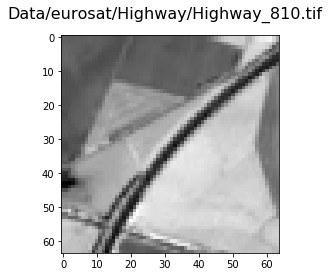

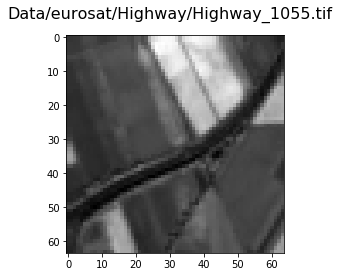

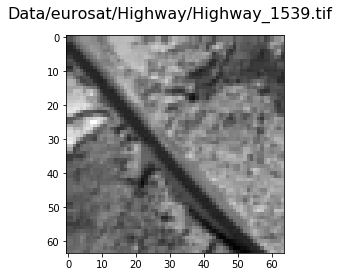

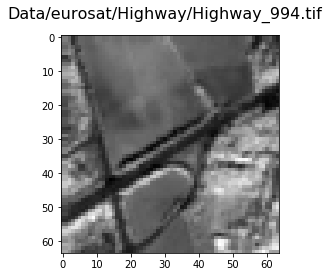

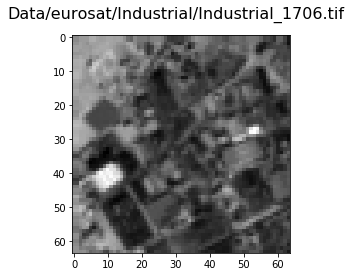

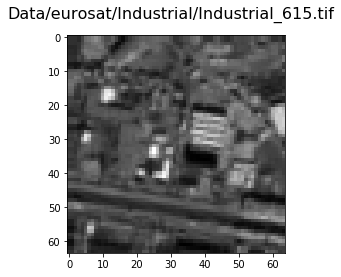

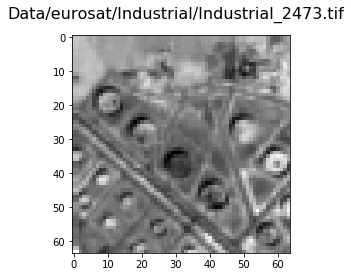

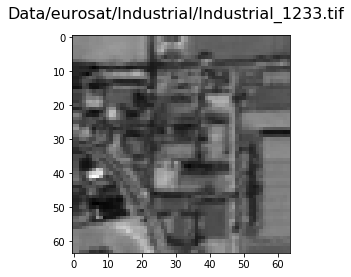

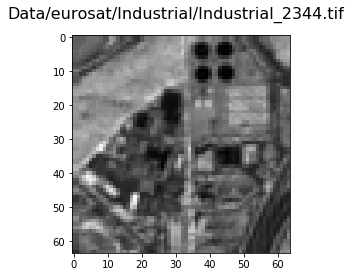

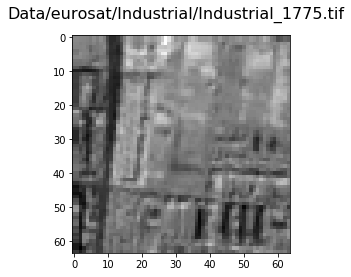

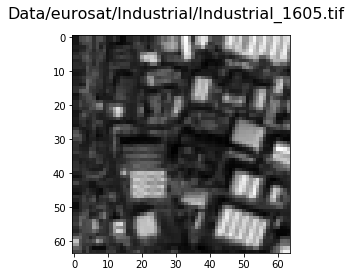

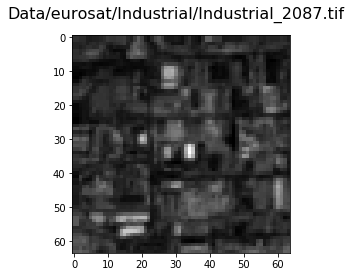

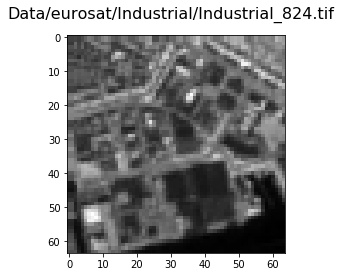

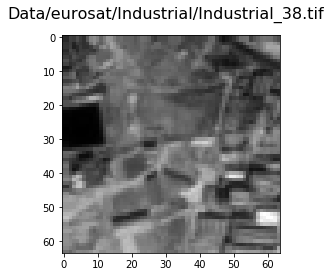

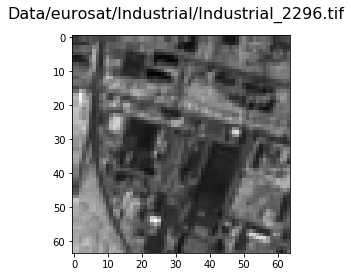

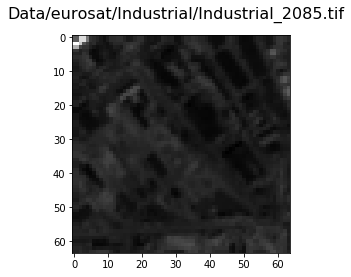

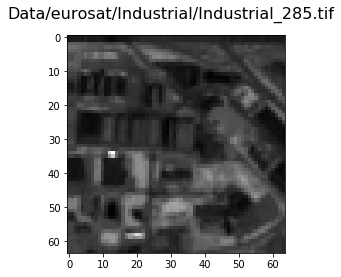

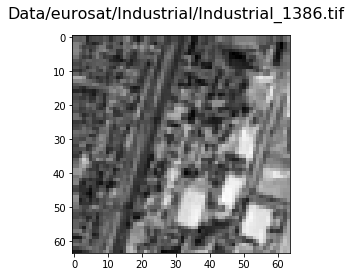

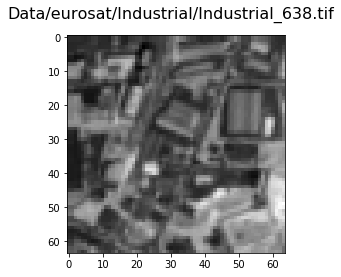

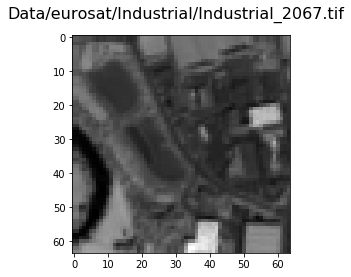

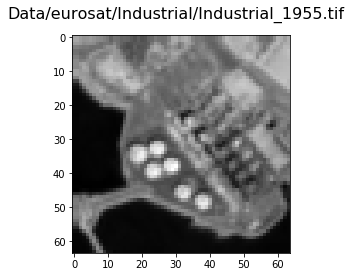

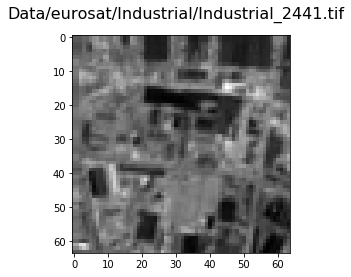

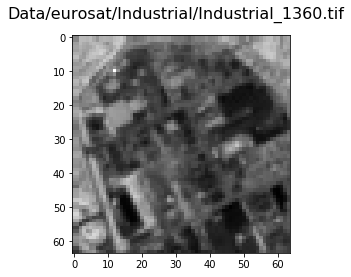

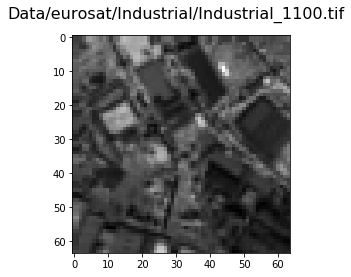

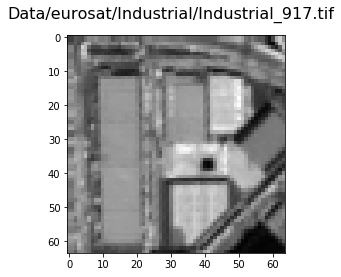

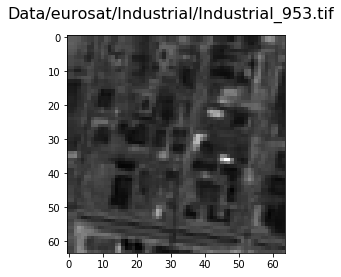

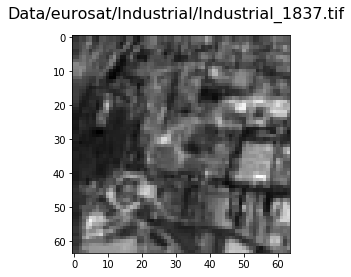

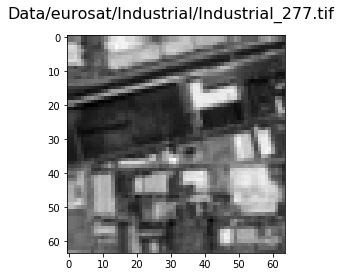

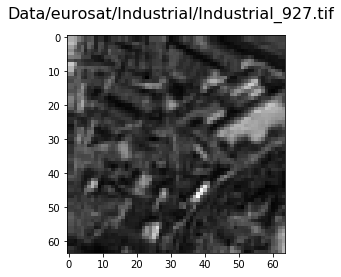

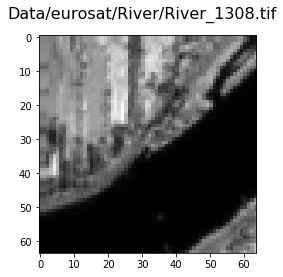

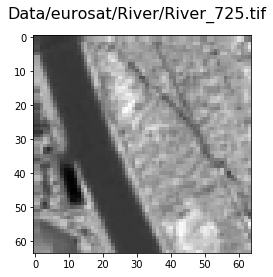

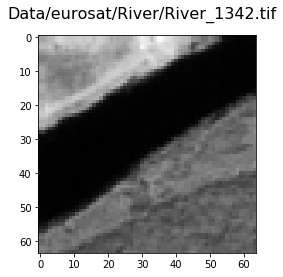

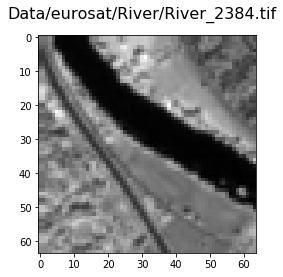

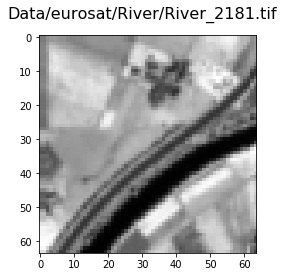

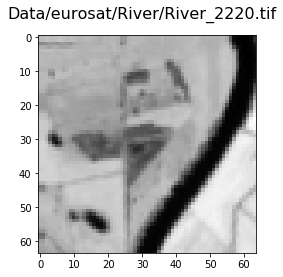

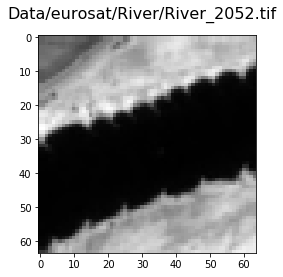

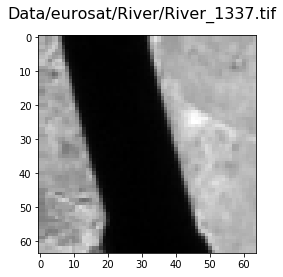

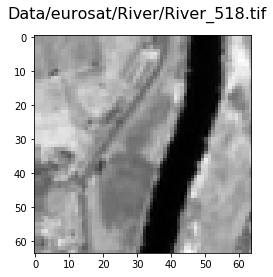

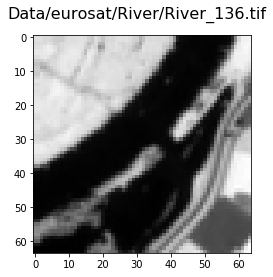

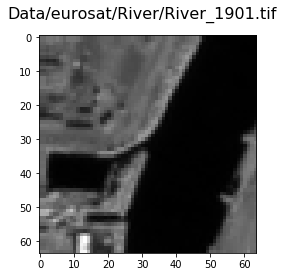

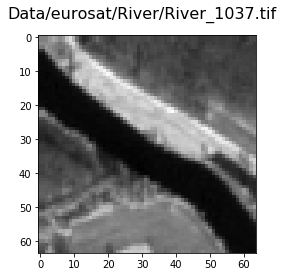

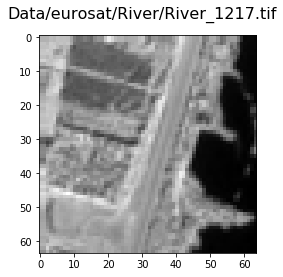

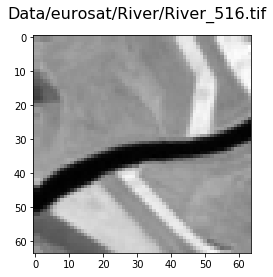

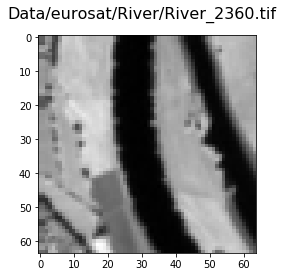

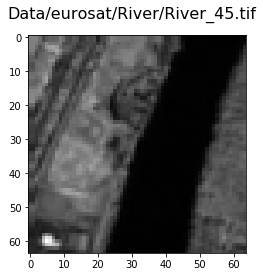

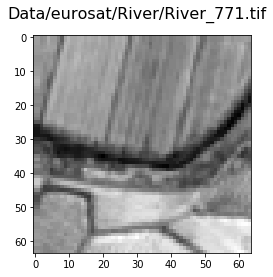

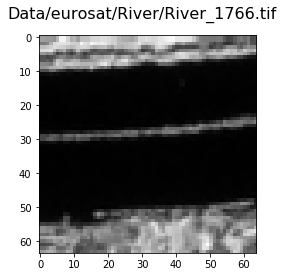

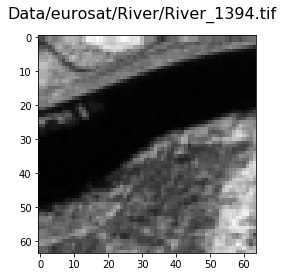

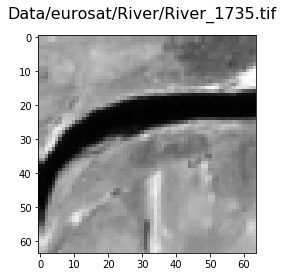

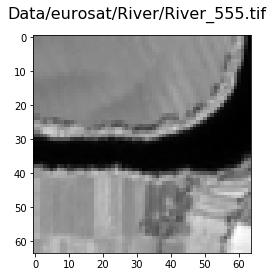

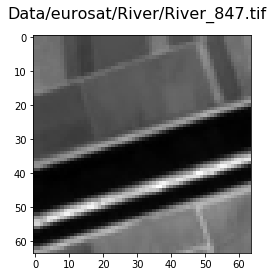

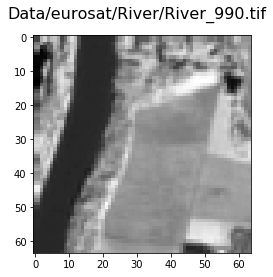

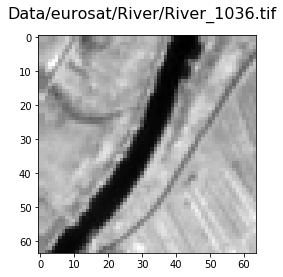

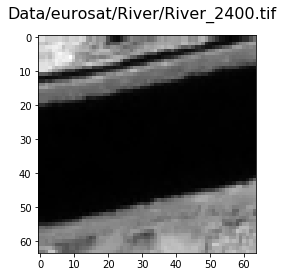

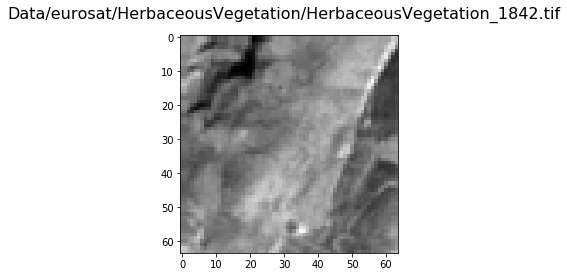

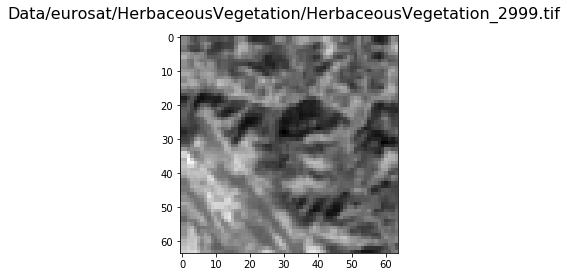

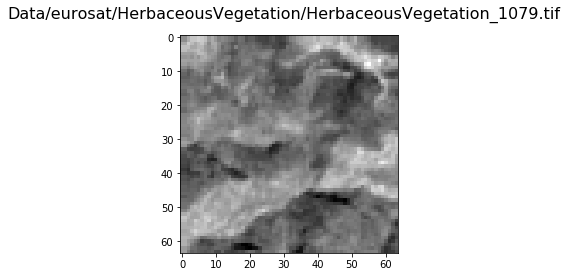

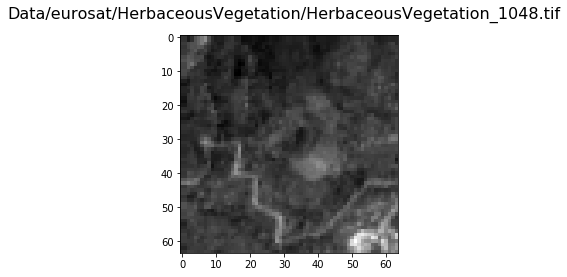

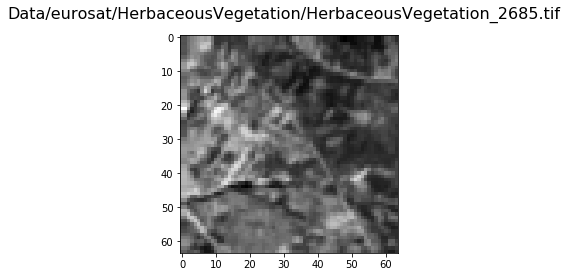

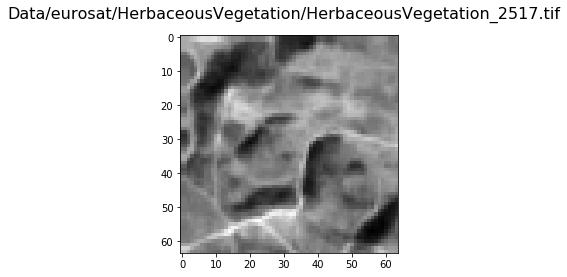

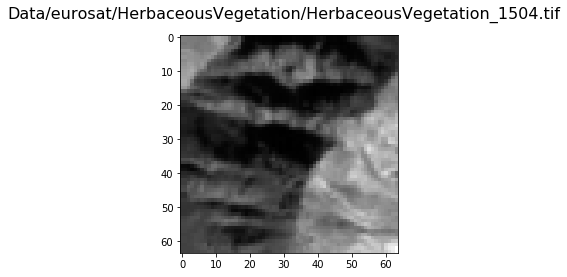

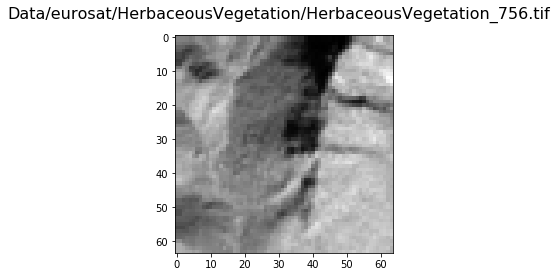

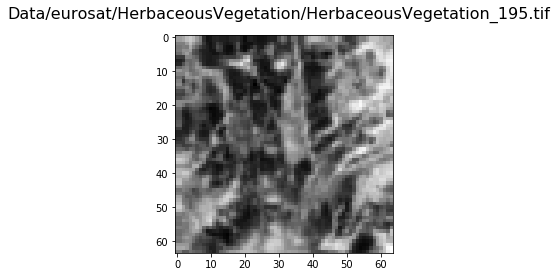

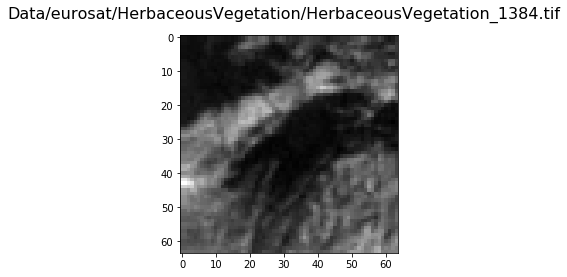

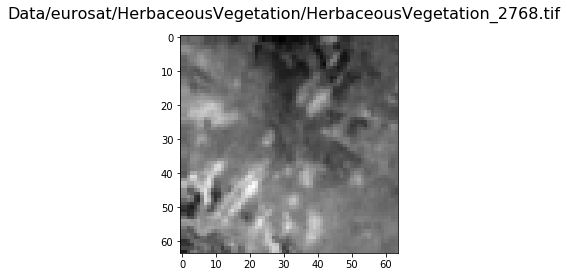

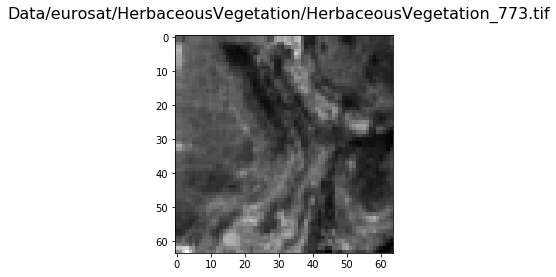

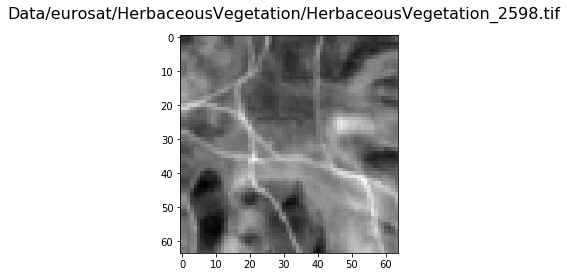

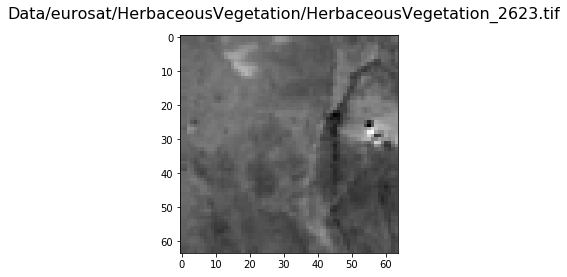

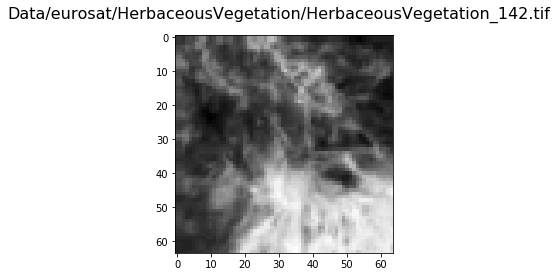

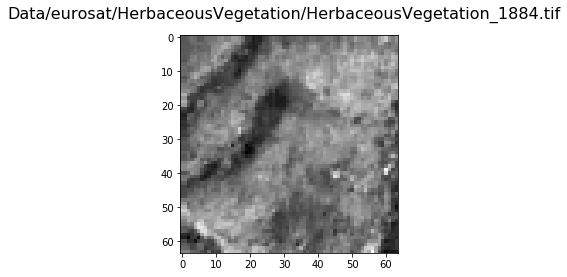

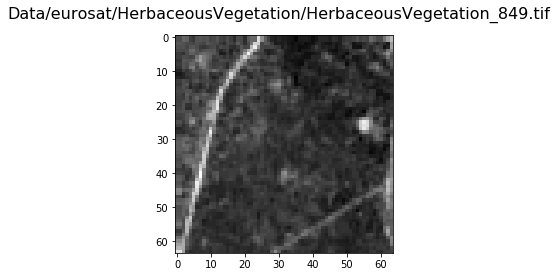

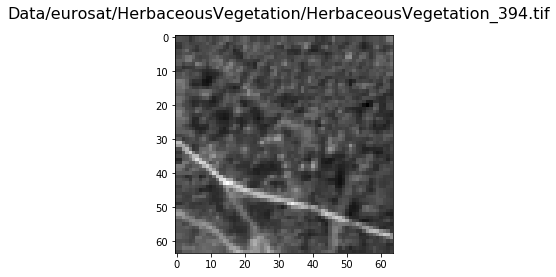

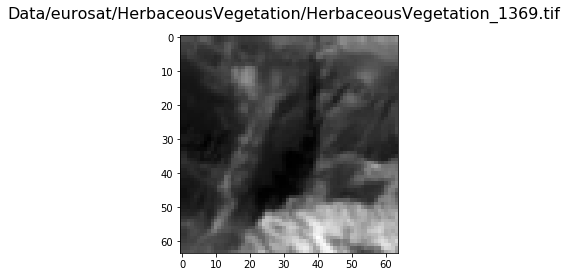

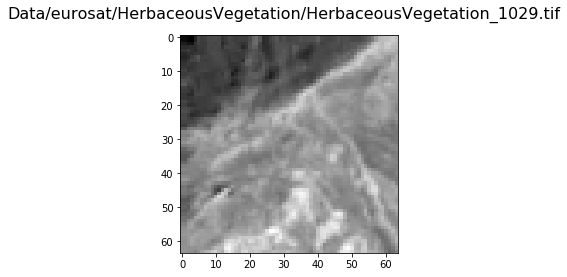

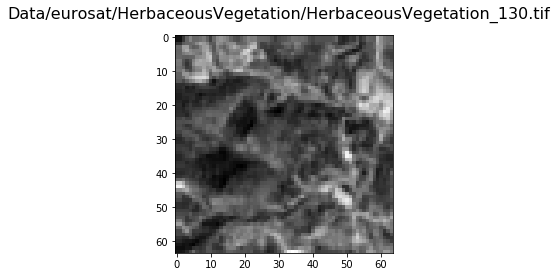

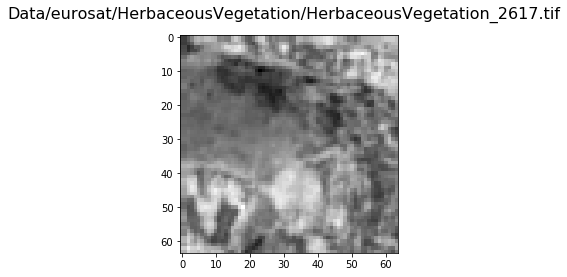

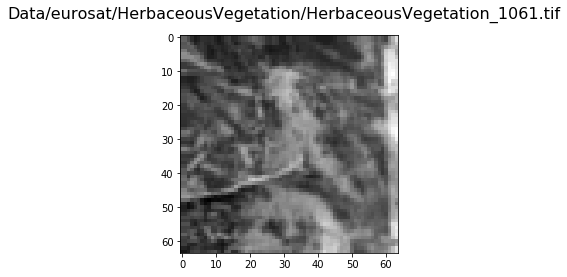

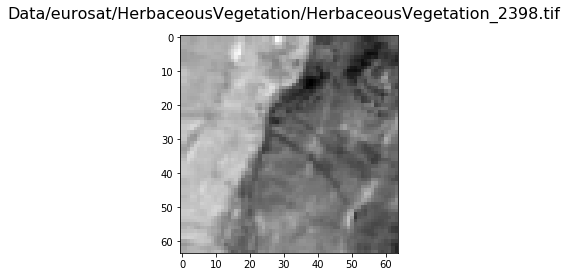

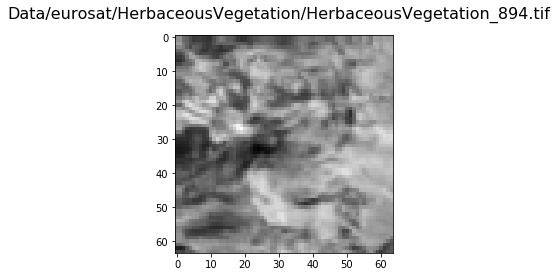

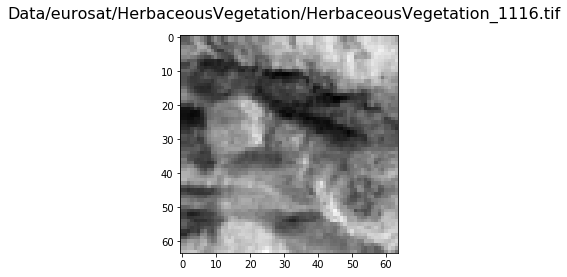

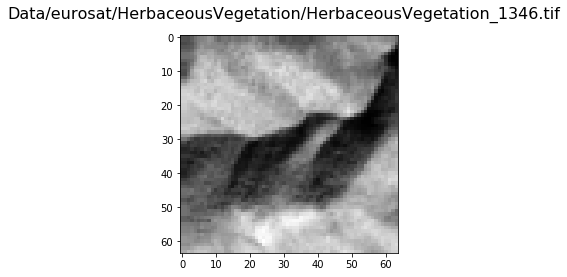

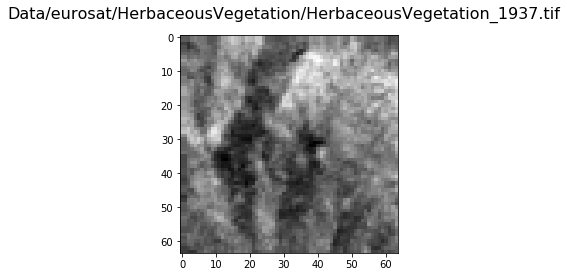

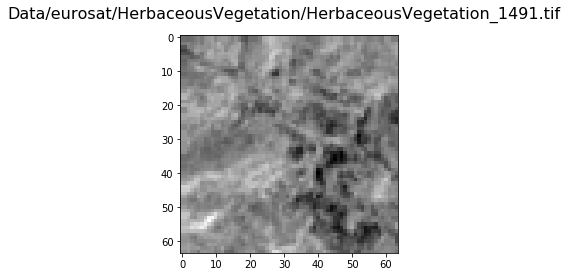

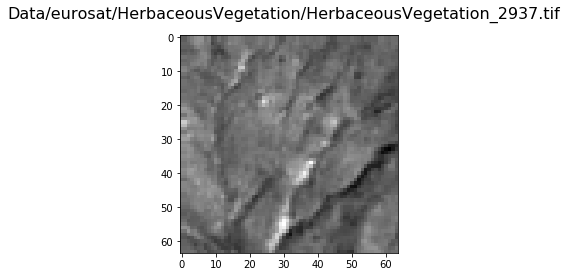

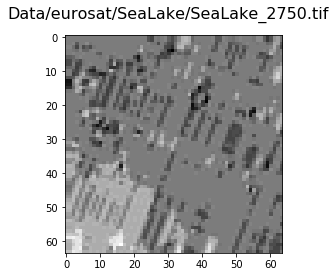

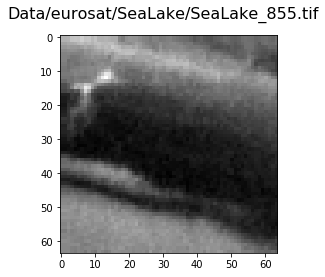

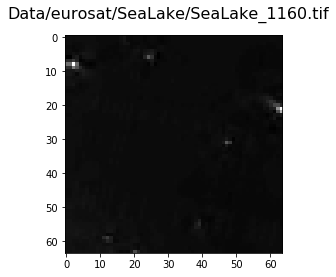

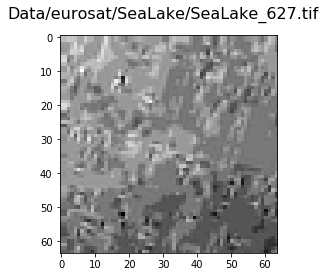

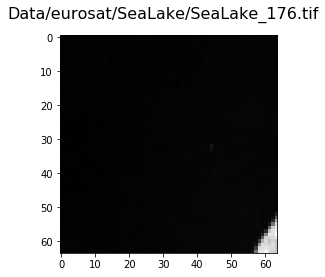

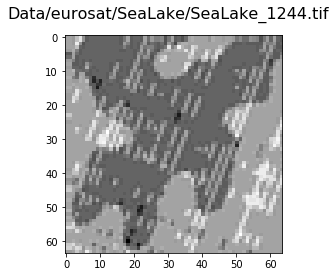

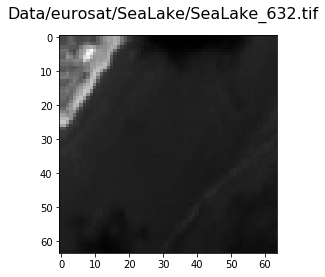

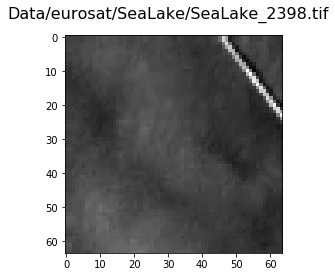

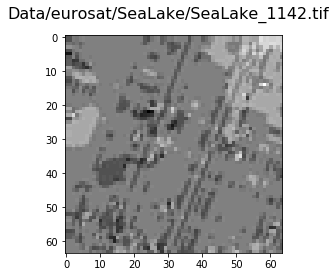

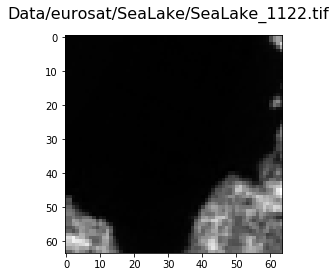

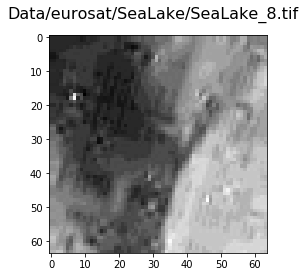

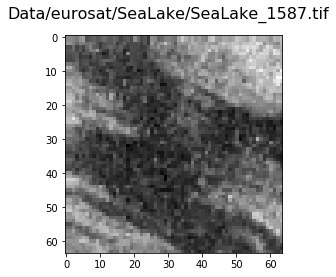

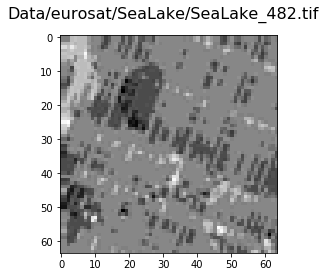

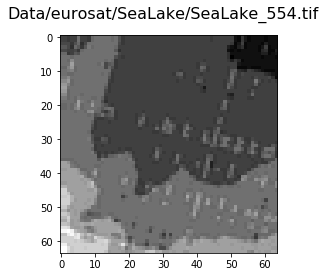

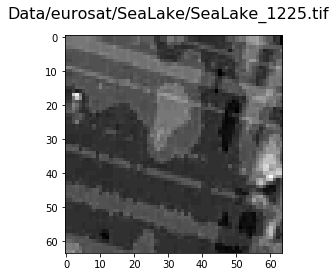

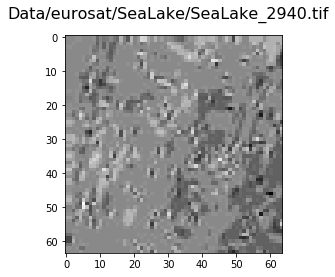

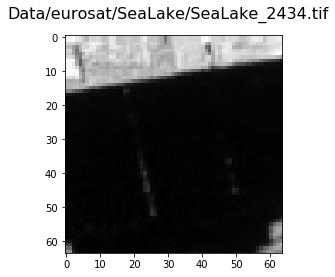

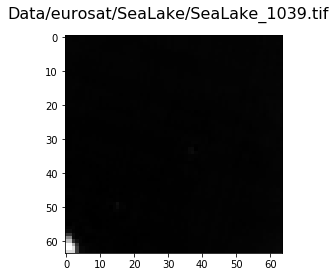

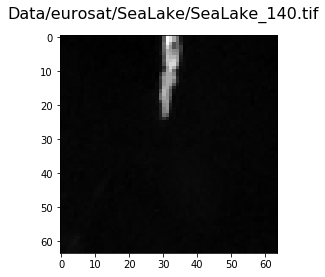

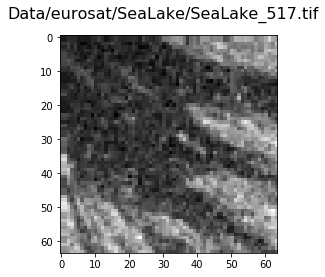

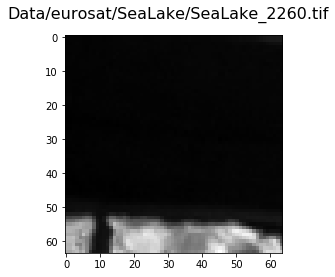

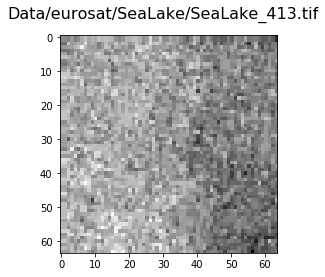

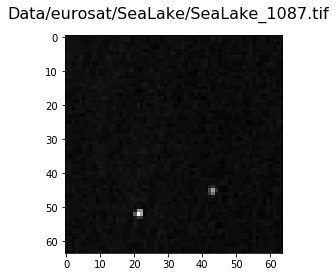

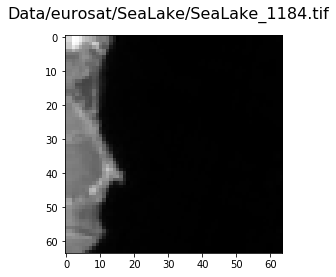

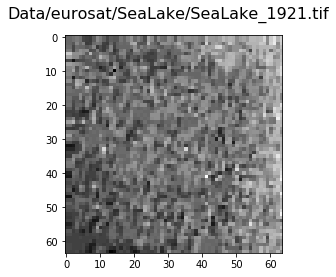

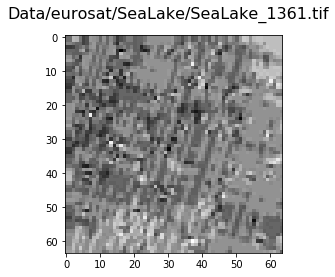

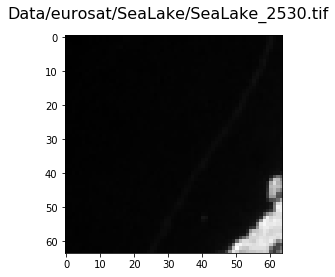

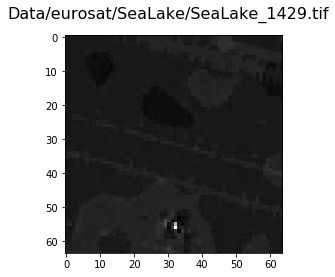

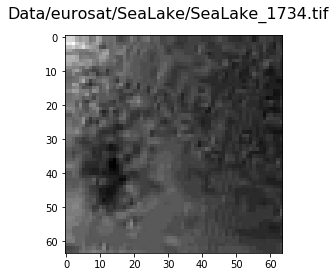

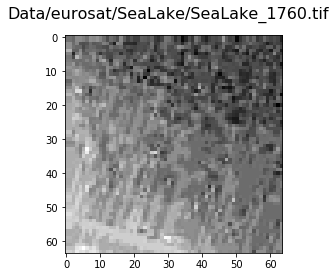

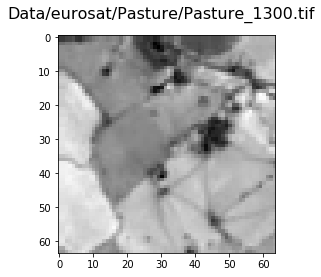

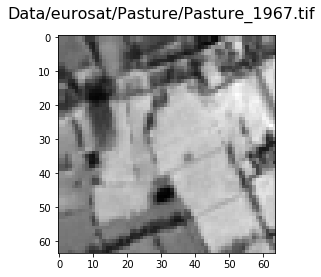

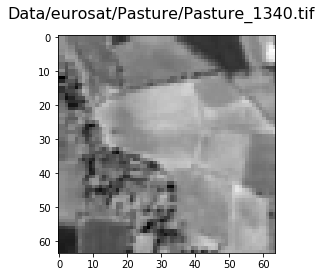

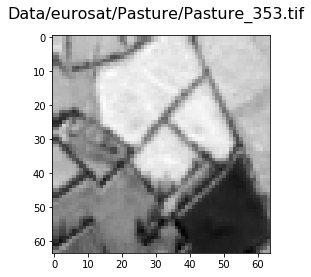

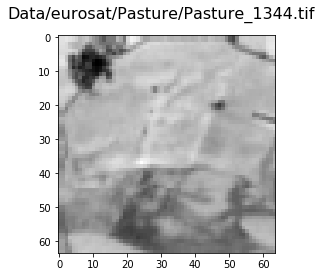

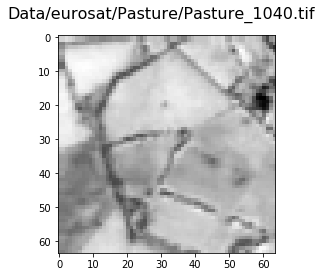

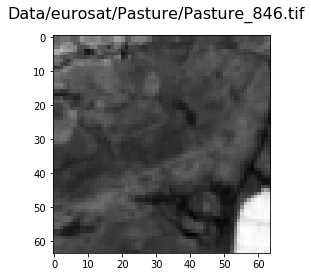

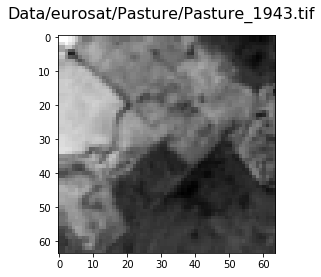

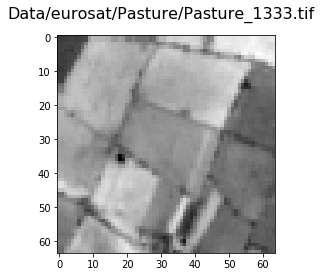

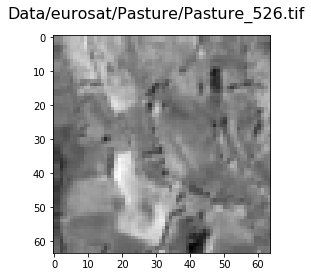

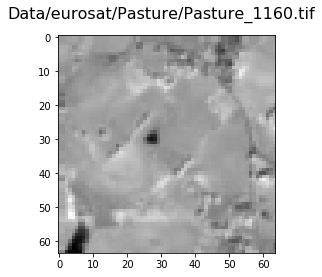

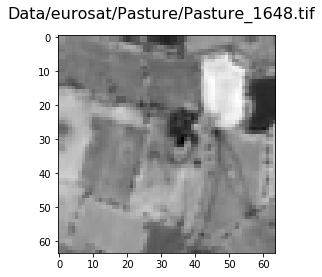

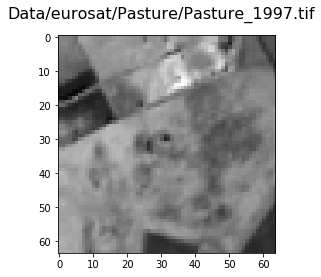

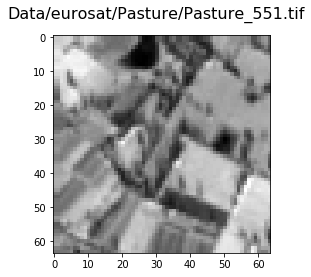

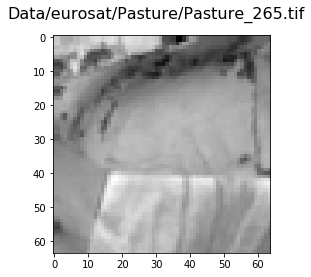

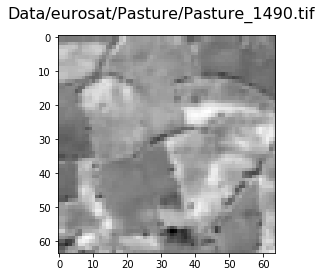

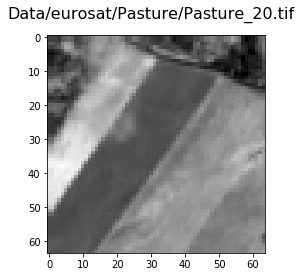

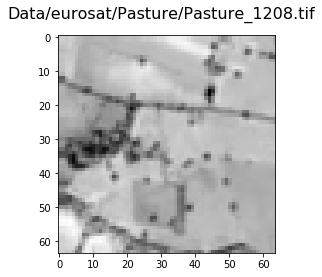

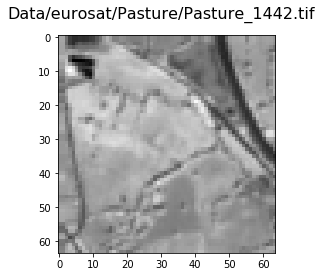

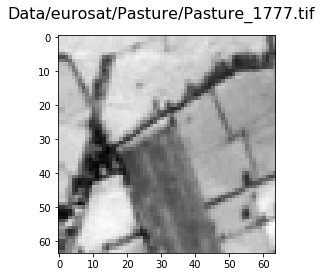

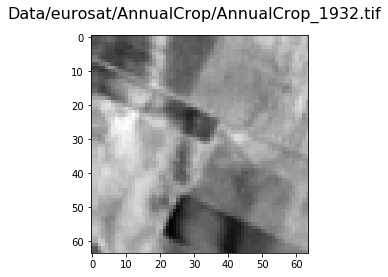

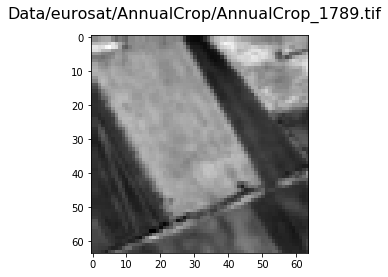

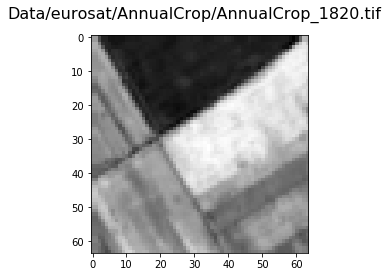

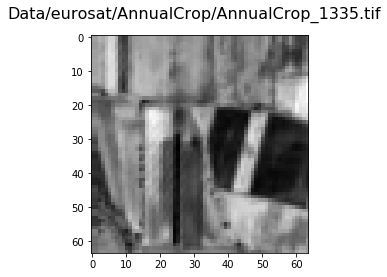

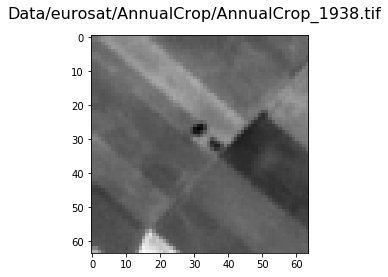

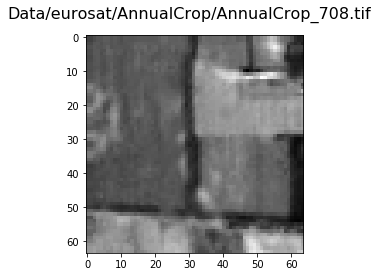

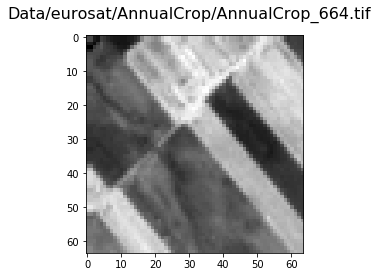

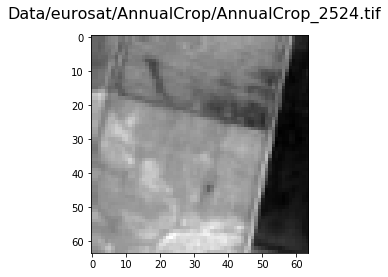

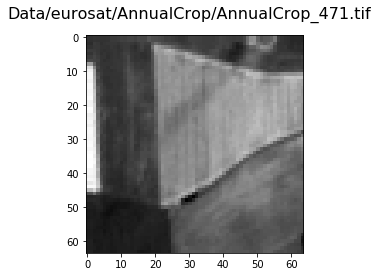

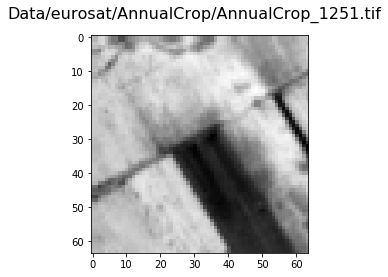

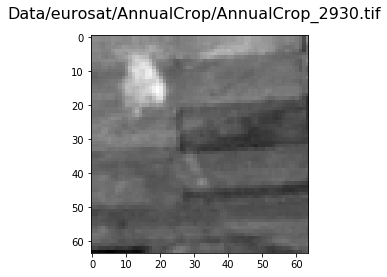

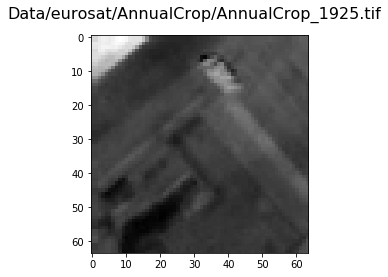

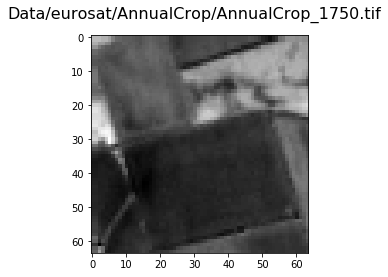

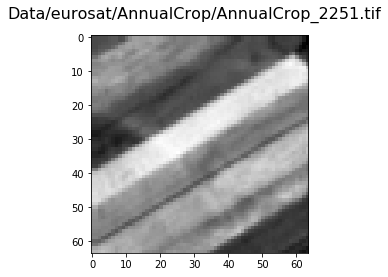

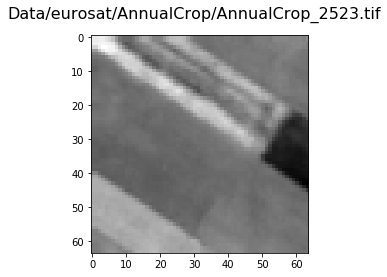

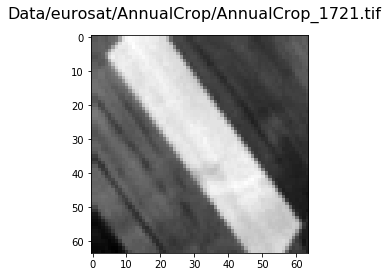

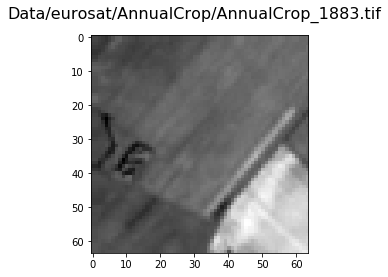

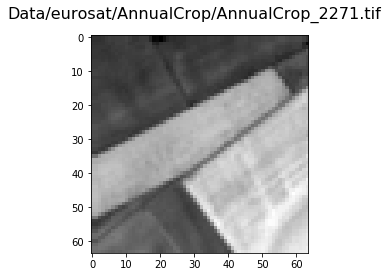

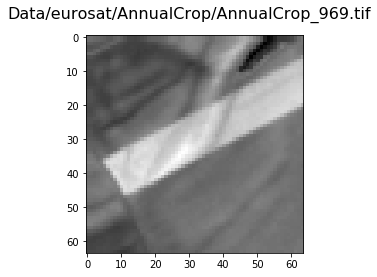

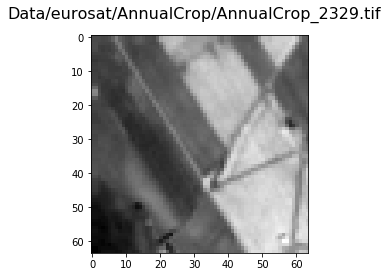

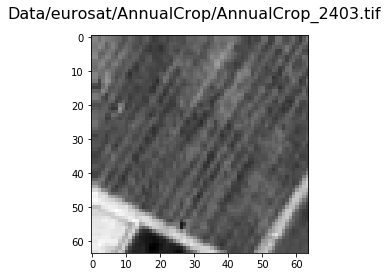

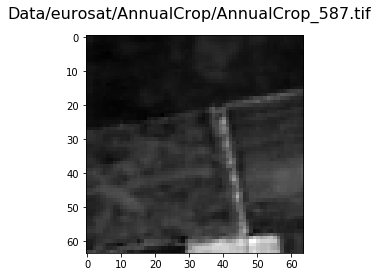

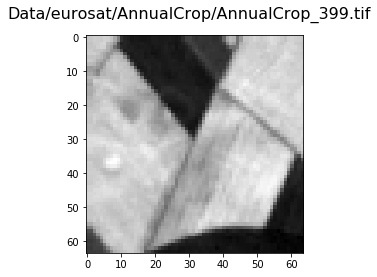

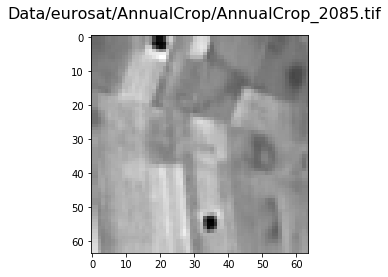

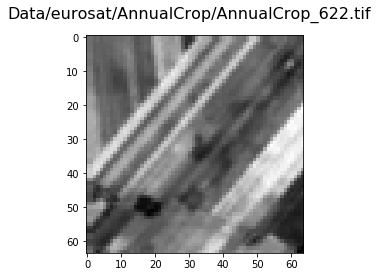

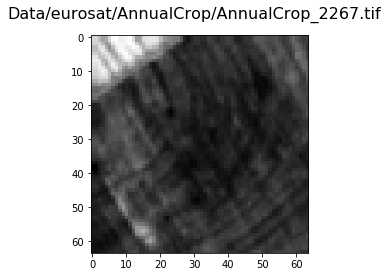

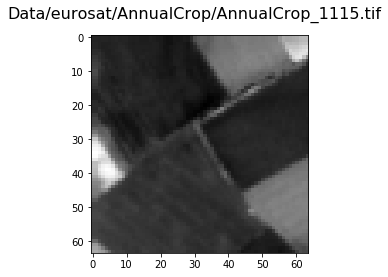

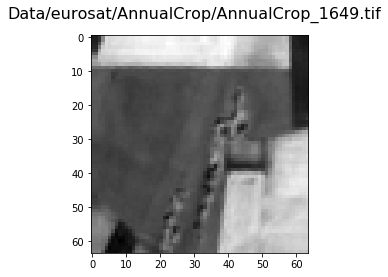

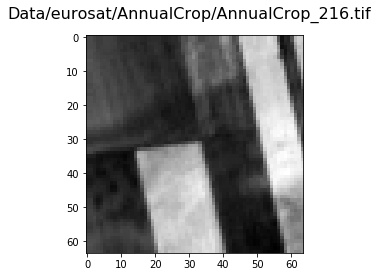

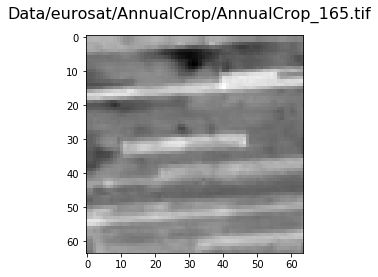

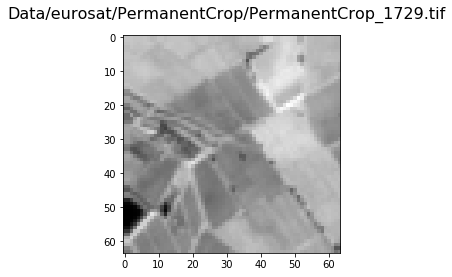

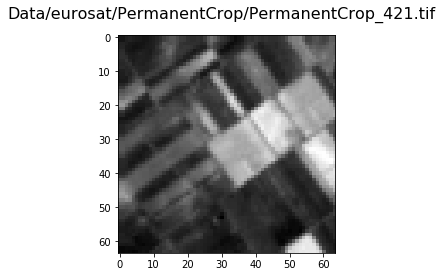

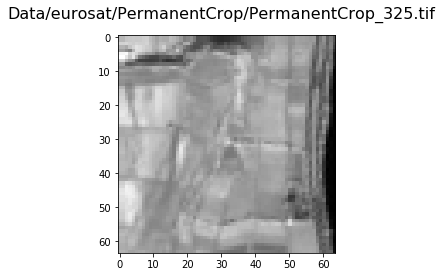

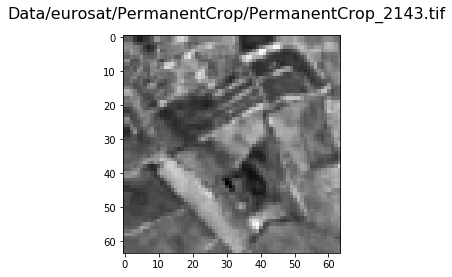

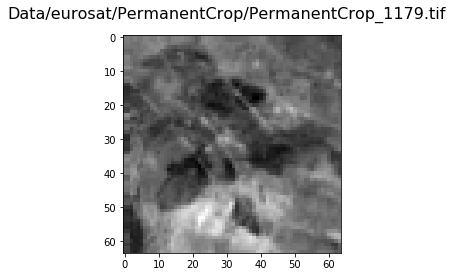

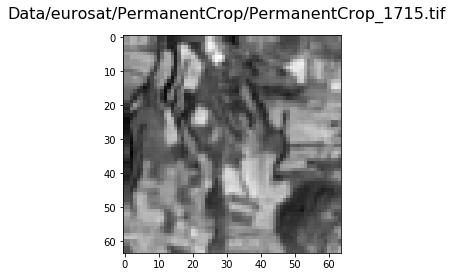

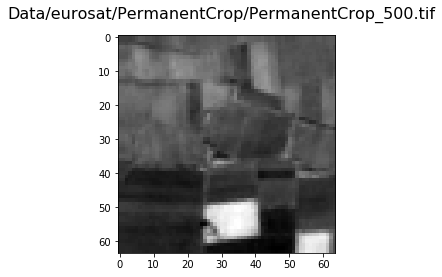

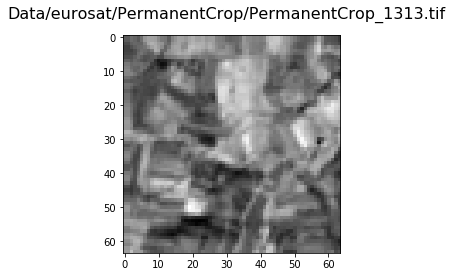

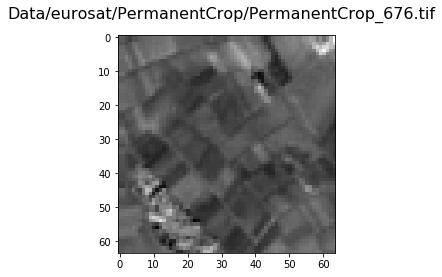

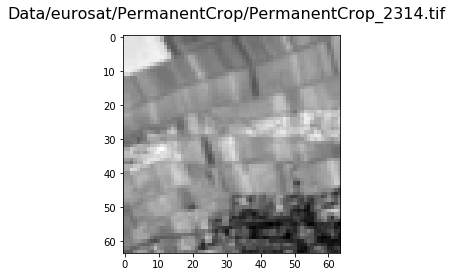

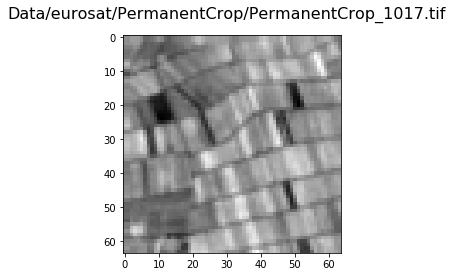

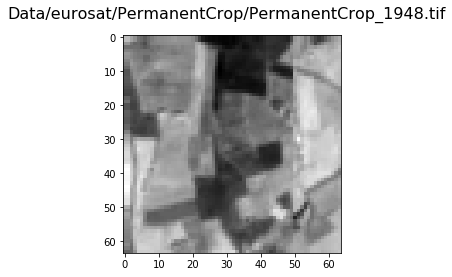

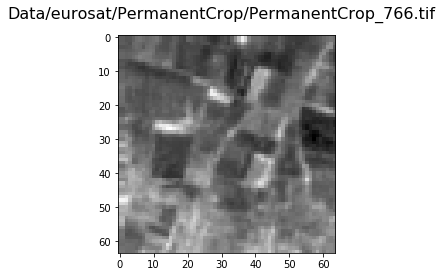

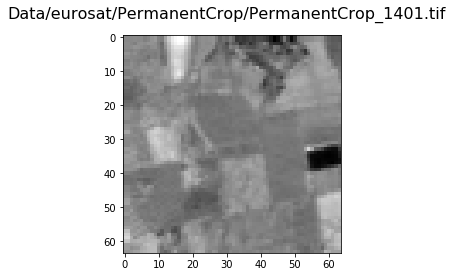

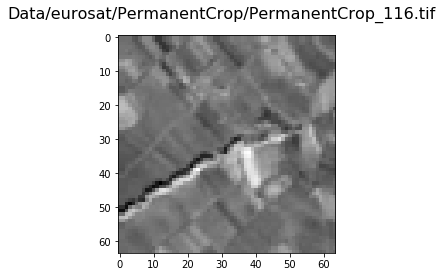

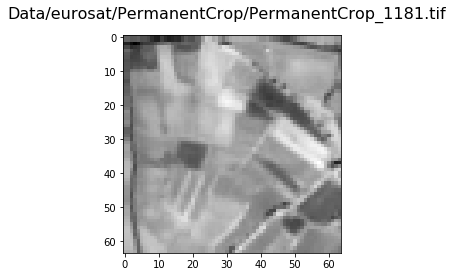

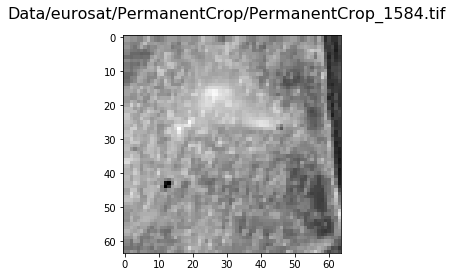

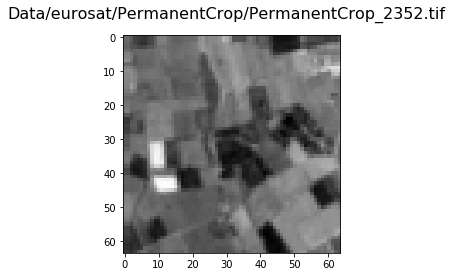

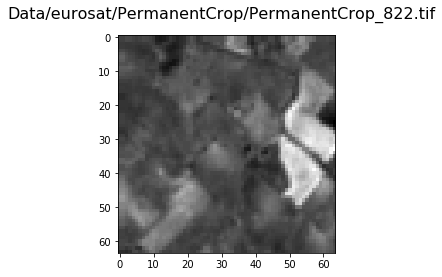

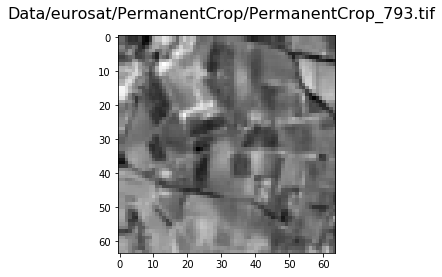

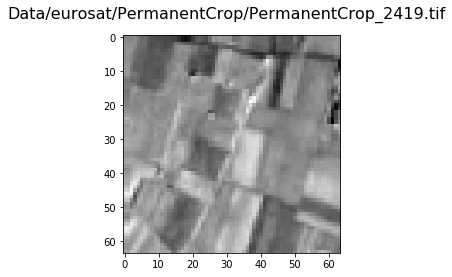

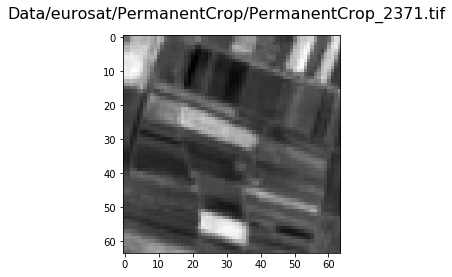

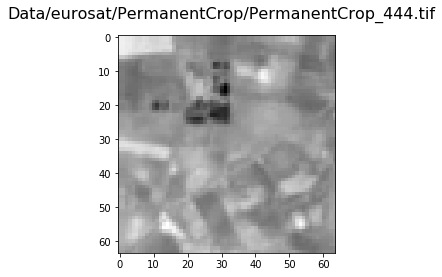

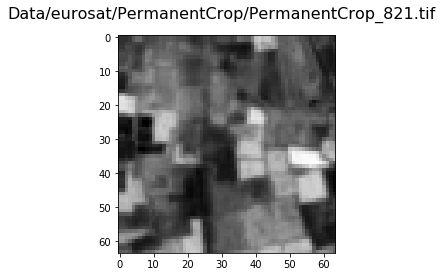

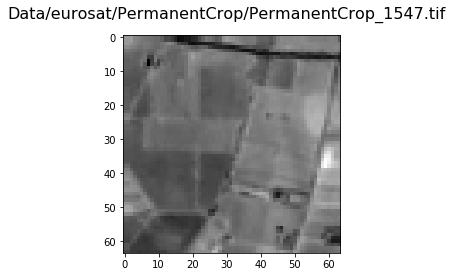

In [130]:
# tiff images
tiffs = glob.glob("Data/eurosat/*/*")
i = 0

for t in tiffs:
    i += 1
    if i % 100 == 0:
        image = load_raster_img(t)
        fig = plt.figure()
        fig.suptitle(t, fontsize=16)
        plt.imshow(image, cmap="gray")

In [132]:
image.shape

(64, 64)